In [8]:
#Importing required Python packages 
import matplotlib.pylab as plt 
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F

# %matplotlib tk
%matplotlib inline

In [9]:
#Define a simple range of values for x and reshape so sklearn likes it.
x = np.linspace(0,1,200)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - 1.

In [10]:
# x = x[:, np.newaxis]
# y = y[:, np.newaxis]

In [11]:
xy  = np.c_[x,y]
# xy

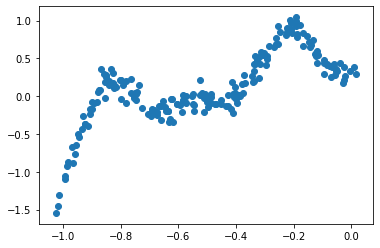

In [12]:
# %matplotlib inline
plt.scatter(x, y)

In [14]:
import pwlf
PWLF = pwlf.PiecewiseLinFit(x, y)
xx = np.linspace(min(x), max(x), num=200)

5
[-1.02275154 -0.86114216 -0.68010558 -0.39803808 -0.21806581  0.01527194]


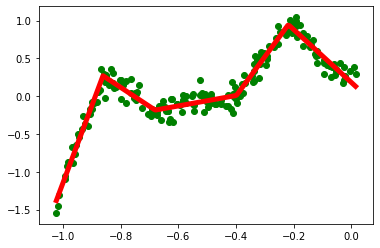

In [15]:
pieces = 5
print(pieces)

# res = PWLF.fitfast(pieces)
res = PWLF.fit(pieces)
print(res)
yy = PWLF.predict(xx)

## PLOTTING THE DATA WITH FITTED CURVE
# %matplotlib tk
plt.scatter(x, y, c='g')
plt.plot(xx, yy, 'r', lw=5)

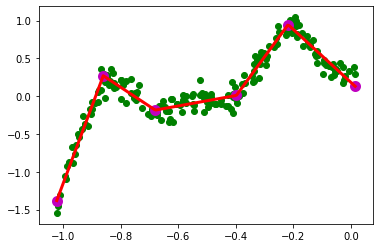

In [16]:
#plotting the end points
plt.scatter(x, y, c='g')
plt.plot(xx, yy, 'r', lw=3)

resy = PWLF.predict(res)
plt.scatter(res, resy, lw=5, c='m')

In [17]:
# This piecewise can be converted to relu neural network
# n_pieces = 5
# break_pts = np.c_[res, resy]
# break_pts

In [18]:
# self made
breaks = PWLF.fit_breaks # = res
slopes = PWLF.calc_slopes()
betas = PWLF.beta
print(breaks)
print(slopes)
print(betas)

[-1.02275154 -0.86114216 -0.68010558 -0.39803808 -0.21806581  0.01527194]
[10.21411623 -2.51131591  0.68703504  5.2021382  -3.49487939]
[ -1.37954517  10.21411623 -12.72543214   3.19835096   4.51510316
  -8.69701759]


In [19]:
eys = [betas[0],]
exs = breaks
ms = slopes
cs = []
# cs = ey[] - m * ex
for index in range(len(breaks)-1):
    
    m = slopes[index]
    x_ = breaks[index]
    c = eys[index] - m*x_
    
    cs.append(c)
    y_ = m * breaks[index+1] + c
    eys.append(y_) 
cs = np.array(cs)
eys = np.array(eys)
eys

array([-1.37954517,  0.27115183, -0.18348821,  0.01030204,  0.94654266,
        0.13105537])

In [20]:
# This piecewise can be converted to relu neural network
n_pieces = 5
break_pts = np.c_[exs, eys]
break_pts

array([[-1.02275154, -1.37954517],
       [-0.86114216,  0.27115183],
       [-0.68010558, -0.18348821],
       [-0.39803808,  0.01030204],
       [-0.21806581,  0.94654266],
       [ 0.01527194,  0.13105537]])

In [21]:
# linearly independent neural network to be designed
W1 = PWLF.calc_slopes()
print('W1 = \n',W1)

W1_ = np.copy(W1)
for i in range(1, len(W1)):
#     print(i)
    W1[i] = W1_[i] - W1_[i-1]
print('updated W1 = \n',W1)

b1 = -res[:-1]*W1
print('b1 = \n',b1)

b2 = resy[0]

W1 = 
 [10.21411623 -2.51131591  0.68703504  5.2021382  -3.49487939]
updated W1 = 
 [ 10.21411623 -12.72543214   3.19835096   4.51510316  -8.69701759]
b1 = 
 [ 10.44650314 -10.95840615   2.17521634   1.79718301  -1.89652223]


In [22]:
# More NN way of function
W2 = np.sign(W1)
W1_ = np.abs(W1)
b1_ = b1*W2
z1 = np.matmul(xx[:,np.newaxis],W1_[np.newaxis, :]) + b1_
a1 = np.maximum(0, z1)# + resy[0]
z2 = np.matmul(a1, W2[:, np.newaxis]) + b2

# # ALTERNATIVE to above method
# z1 =np.matmul(xx[:,np.newaxis],W1[np.newaxis, :]) + b1
# a1 = np.maximum(0, W2 * z1)# + resy[0]
# z2 = np.matmul(a1, W2[:, np.newaxis]) + b2

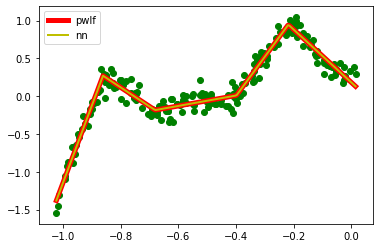

In [23]:
plt.scatter(x, y, c='g')
plt.plot(xx, yy, 'r', lw=5, label='pwlf')
# # plt.plot(xx, a1[:,0] + a1[:,1] + resy[0]) # used during testing
plt.plot(xx, z2, 'y-', lw=2, label='nn')
plt.legend()

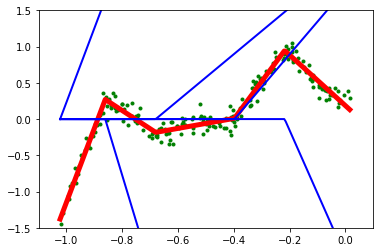

In [24]:
%matplotlib inline
plt.xlim(-1.1,0.1)
plt.ylim(-1.5,1.5)
plt.scatter(x, y, marker='.', c='g')
plt.plot(xx, z2, 'r', lw=5)
for a1i, w2i in zip(a1.T, W2):
    plt.plot(xx, a1i*w2i, 'b', lw=2)

In [17]:
# constructing decision tree equivalent to above piecewise network
class Question:

    def __init__(self, value):
        self.value = value

    def match(self, data):
        val = data
        return val <= self.value

    def __repr__(self):
        return "Is X <= %s?" % (str(self.value))


class Leaf:
    def __init__(self, m, c, data=None):
        self.slope = m
        self.intercept = c

    def __repr__(self):
        return f"m:{self.slope} c:{self.intercept}"


class Decision_Node:
    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

def print_tree(node, spacing="    "):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing +'====='+ f"m={node.slope}  ,c={node.intercept}")
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "   ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "   ")

    Is X <= -0.678881214828208?
    --> True:
       Is X <= -0.8673288383490941?
       --> True:
          =====m=10.681928590682503  ,c=9.52563021957333
       --> False:
          =====m=-2.288951231827487  ,c=-1.7243879092499643
    --> False:
       Is X <= -0.3916560435186408?
       --> True:
          =====m=0.6691953296491278  ,c=0.28384222204516596
       --> False:
          Is X <= -0.23284544567340065?
          --> True:
             =====m=5.7981423917791455  ,c=2.2926253358155653
          --> False:
             =====m=-3.1472567381092795  ,c=0.20972988869024456


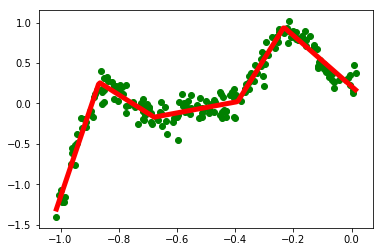

In [18]:
def make_tree_from_pwlf(break_pts, indices):
    if len(break_pts) == 1:
#         print('constructing leaf')
#         print('index=', indices)
        indx = indices[0]
        m = slopes[indx]
        c = cs[indx]
        # print('w1, b1, w2, b2 = ', w1, B1, w2, B2)
        # print('m, c = ', m , c)

        # return Leaf(W1[0][indx]* W2[indx][0], b1[indx]*W2[indx][0] + b2[0])
        return Leaf(m, c)

    mid = len(break_pts)//2 # mid point of break point
    question = Question(break_pts[mid]) # make mid point a question
    points_left = break_pts[:mid] # left points
    points_right = break_pts[mid:] # right points 
    index_left = indices[:mid] # indices of left points
    index_right = indices[mid:] # indices of right points
    
#     print('constructing Branch')
#     print('index=', indices)
#     print(index_left, index_right)
#     print(len(index_left), len(index_right))
    yes_answer = make_tree_from_pwlf(points_left, index_left) # yes answer for the left points
    no_answer = make_tree_from_pwlf(points_right, index_right) # no answer for the right points
    return Decision_Node(question, yes_answer, no_answer) # construct recursive tree structure

index_points = np.arange(0, len(W1))
eqv_tree = make_tree_from_pwlf(exs[:-1], index_points)
print_tree(eqv_tree)

plt.scatter(x, y, c='g')
plt.plot(xx, yy, 'r', lw=5)

In [19]:
# understanding of the parameters in function approximator using neural networks (till now):
'''
1. the first and sencond weights define the slope of each piece
2. the lowest end point has output 0 at minimum, the last bias(b2) gives the lowest y-end point
3. the lowest end point always gives output [theoritically: 0 below its rectification]
4. the units greater than the end points are linearly dependent on previous pieces:
    a. the weights are covering up for error of previous unit
    b. despite using max(0, z), we get continuous plot, because of the previous pieces output and last bias
       to provide value greater than 0 for the data in its scope.
5. the pieces are always linearly dependent and can't break relation with other pieces
6. the pieces with similar weights and biases are useless
7. the optimization of the lowest end point piece is maximum, the optimization of higher end point piece is minimum
7. the optimization changes the parameter(w/b) of the piece that has not caused the error explicitly:
    -the backpropagation gives the error credit to the piece which is already optimized but participates to
     provide y-pos support for later end units.( the optimization is inefficient )
    -the error changes the network structure too much, till it gets stuck in local/global optima
    
'''

"\n1. the first and sencond weights define the slope of each piece\n2. the lowest end point has output 0 at minimum, the last bias(b2) gives the lowest y-end point\n3. the lowest end point always gives output [theoritically: 0 below its rectification]\n4. the units greater than the end points are linearly dependent on previous pieces:\n    a. the weights are covering up for error of previous unit\n    b. despite using max(0, z), we get continuous plot, because of the previous pieces output and last bias\n       to provide value greater than 0 for the data in its scope.\n5. the pieces are always linearly dependent and can't break relation with other pieces\n6. the pieces with similar weights and biases are useless\n7. the optimization of the lowest end point piece is maximum, the optimization of higher end point piece is minimum\n7. the optimization changes the parameter(w/b) of the piece that has not caused the error explicitly:\n    -the backpropagation gives the error credit to the p

In [20]:
# we can rectify the input :before the change of domain OR output :after the chane of domain
# we can rectify them interchangabely
# we can also rectify after in 2 ways:
                #rectify in s shaped curve : A1 = Z1.clamp(min = lower_end_point, max = upper_end_point)
                #rectify in / shaped pieces: A1 = Z1 if { Z1  in range(lower_end_point, upper_end_point) }
                #                               = 0  else
# both are similar for backpropagation, because the derrivative is 0 outside the range
# the bias are linearly dependent on s but not on the /


#we can also rectify before:
                #rectify the input in its range, forward propagate
                #backpropagate to change the slope and the range itself


In [21]:
# rectifying the units in s shaped curve
'''
Algorithm:
forward propagation
1: Z1 = X.dot(W1) + b1  # the weight and bias can produce lep, uep for each segment when sorted
2: A1 = Z1.clamp_bet(uep , lep) # the end point support is given by units below it in sorted form
3: Z2 = A1.dot(W2) - leps[1:].sum()  # W2 is all ones :.can use A1.sum()

error calculation
4. Err = Z2 - Y

backpropagation
5. dE/dA1 = Err.(W2.T)
6. dE/dZ1 = (Z1 in range(uep, lep) as int) * d
7. dE/dW = .......
8. dE/db = .......
'''

'\nAlgorithm:\nforward propagation\n1: Z1 = X.dot(W1) + b1 # the weight\n2: A1 = Z1.clamp_bet(0, uep-lep) # the end point support is given by units below it in sorted form\n3: Z2 = A1.dot(W2) + lep[0]  # W2 is all ones :.can use A1.sum()\n\nerror calculation\n4. Err = Z2 - Y\n\nbackpropagation\n5. dE/dA1 = Err.(W2.T)\n6. dE/dZ1 = (Z1 in range(0, uep-lep) as int) * d\n7. dE/dW = .......\n8. dE/db = .......\n'

In [22]:
print(slopes) # slopes of individual pieces
print(cs) # y-intercepts of individual pieces
print(exs) # end points in x axis ; from first end point to last
print(eys) # end points in y axis ; from first to last end point

[10.68192859 -2.28895123  0.66919533  5.79814239 -3.14725674]
[ 9.52563022 -1.72438791  0.28384222  2.29262534  0.20972989]
[-1.01410305 -0.86732884 -0.67888121 -0.39165604 -0.23284545  0.01333654]
[-1.30694609  0.2608855  -0.17046192  0.02174783  0.94255429  0.16775637]


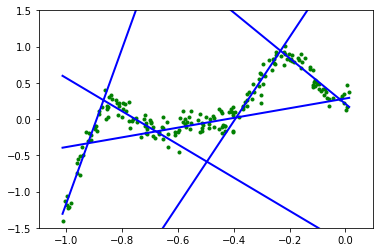

In [23]:
z1 = np.matmul(xx[:,np.newaxis],slopes[np.newaxis, :]) + cs

%matplotlib inline
plt.xlim(-1.1,0.1);plt.ylim(-1.5,1.5)
plt.scatter(x, y, marker='.', c='g')
for z1i in z1.T:
    plt.plot(xx, z1i, 'b', lw=2)

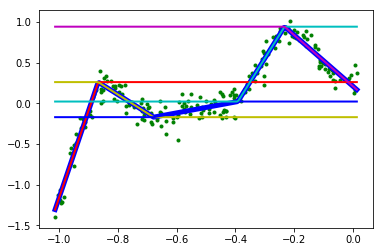

In [26]:
z1 = np.matmul(xx[:,np.newaxis],slopes[np.newaxis, :]) + cs
leps = eys[:-1]
ueps = eys[1:]
a1 = []
for lep, uep, z1i in zip(leps, ueps, z1.T):
    if lep > uep:
        t = uep
        uep = lep
        lep = t
#     print(z1i)
    a1.append(np.clip(z1i, lep, uep))
a1 = np.array(a1).T
z2 = np.sum(a1, axis=1)- leps[1:].sum()
    
%matplotlib inline
# plt.xlim(-1.1,0.1);plt.ylim(-1.5,1.5)
plt.scatter(x, y, marker='.', c='g')
plt.plot(xx, z2, 'b', lw=5)

color_seq = ['r', 'y', 'b', 'c', 'm']
for i, a1i in enumerate(a1.T):
    plt.plot(xx, a1i,  lw=2, c=color_seq[i])
# print(a1[0,:])
# print(z2[0])
# print(leps)

In [25]:
# More NN way of function
# Create neural netwrok equivalent to above (currently unsucceeded)

# W2_ = np.sign(slopes)
# b2_ = resy[0]
# W1_ = np.abs(slopes)
# b1_ = cs*W2_

# low_pts =[]
# high_pts = []
# for lep, uep in zip(leps,ueps):
#     if lep > uep:
#         t = uep
#         uep = lep
#         lep = t
#     low_pts.append(lep)
#     high_pts.append(uep)
# low_pts = np.array(low_pts)
# high_pts = np.array(high_pts)

# print(low_pts)
# print(high_pts)

# z1 = np.matmul(xx[:,np.newaxis],W1_[np.newaxis, :]) + b1_
# # a1 = np.maximum(low_pts, z1)
# # a1 = np.clip(z1, low_pts, high_pts)
# a1 = z1
# z2 = np.matmul(a1, W2_[:, np.newaxis]) + b2_
    
# %matplotlib inline
# plt.xlim(-1.1,0.1);plt.ylim(-1.5,1.5)
# plt.scatter(x, y, marker='.', c='g')
# plt.plot(xx, z2 - leps[1:].sum(), 'b', lw=5)

# color_seq = ['r', 'y', 'b', 'c', 'm']
# for i, a1i, w2i in zip(range(len(W2)), a1.T, W2):
#     plt.plot(xx, a1i*w2i, lw=2, c=color_seq[i])

In [27]:
# rectifying the units in / shaped pieces
'''
Algorithm:
forward propagation
1: Z1 = X.dot(W1) + b1 # the weight
2.i: mask = Z1.between(uep, lep) # the end point support is given by units below it in sorted form
  ii: A1 = mask * Z1
3: Z2 = A1.dot(W2) + lep[0]  # W2 is all ones :.can use A1.sum()

error calculation
4. Err = Z2 - Y

backpropagation
5. dE/dA1 = Err.(W2.T)
6. dE/dZ1 = (Z1 in range(uep, lep) as int) * d
7. dE/dW = .......
8. dE/db = .......
'''

'\nAlgorithm:\nforward propagation\n1: Z1 = X.dot(W1) + b1 # the weight\n2.i: mask = Z1.between(uep, lep) # the end point support is given by units below it in sorted form\n  ii: A1 = mask * Z1\n3: Z2 = A1.dot(W2) + lep[0]  # W2 is all ones :.can use A1.sum()\n\nerror calculation\n4. Err = Z2 - Y\n\nbackpropagation\n5. dE/dA1 = Err.(W2.T)\n6. dE/dZ1 = (Z1 in range(uep, lep) as int) * d\n7. dE/dW = .......\n8. dE/db = .......\n'

In [34]:
eys

array([-1.30694609,  0.2608855 , -0.17046192,  0.02174783,  0.94255429,
        0.16775637])

[-1.30694609 -0.17046192 -0.17046192  0.02174783  0.16775637]
[0.2608855  0.2608855  0.02174783 0.94255429 0.94255429]
(200, 5)


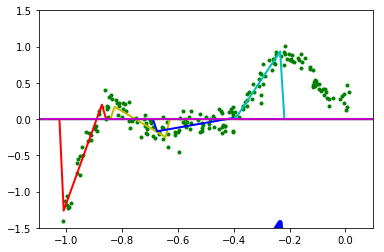

In [35]:
W2_ = np.sign(slopes)
b2_ = resy[0]
W1_ = np.abs(slopes)
b1_ = cs*W2_

low_pts =[]
high_pts = []
for lep, uep in zip(leps,ueps):
    if lep > uep:
        t = uep
        uep = lep
        lep = t
    low_pts.append(lep)
    high_pts.append(uep)
low_pts = np.array(low_pts)
high_pts = np.array(high_pts)

print(low_pts)
print(high_pts)
xx = np.linspace(min(x)-1, max(x)+1, num=200)
z1 = np.matmul(xx[:,np.newaxis],W1_[np.newaxis, :]) + b1_
a1 = np.where(np.logical_and(z1>=low_pts, z1<=high_pts), z1, 0)
# a1 = np.maximum(low_pts, z1)
# a1 = np.clip(z1, low_pts, high_pts)
# a1 = z1
print(a1.shape)
z2 = np.matmul(a1, W2_[:, np.newaxis]) + b2_
    
%matplotlib inline
plt.xlim(-1.1,0.1);plt.ylim(-1.5,1.5)
plt.scatter(x, y, marker='.', c='g')
plt.plot(xx, z2 - leps[1:].sum(), 'b', lw=5)

color_seq = ['r', 'y', 'b', 'c', 'm']
for i, a1i, w2i in zip(range(len(W2)), a1.T, W2):
    plt.plot(xx, a1i*w2i, lw=2, c=color_seq[i])